# Tomografisk rekonstruktion - 2D

I denne Notebook vil vi eksperimentere med to forskellige rekonstruktionsmetoder; 1) Filtered Backprojection og 2) Algebraisk rekonstruktion. Vi vil arbejde med syntetisk data, dvs. data computeren genererer ved at lave projektioner gennem et såkaldt fantom (kunstigt billede). Vi arbejder i 2D for at gøre beregningstiden kort. 

Prøv at gå igennem denne Notebook og afprøv forskellige parametre i rekonstruktionerne. Prøv at bruge flere eller færre projektioner, og prøv at sætte støjniveauet op eller ned. 


#### Tips
1) Kør en celle med shift+Enter eller ctrl+Enter

2) Husk, det er vigtigt for computeren hvilken rækkefølge du udfører kommandoer i. Dvs. hvis du ændrer en parameter højere oppe er det ikke nok at køre den enkelte celle igen. Du skal køre alle efterfølgende celler den har en effekt på. Hvis du er i tvivl, så genstart Notebooken (Kernel>Restart i menuen) og kør det hele igen fra toppen.

## Indlæs biblioteker

Først indlæser vi de Python bibliteker og funktioner vi får brug for. 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

#from myplot import show2D
from cil.utilities.display import show2D

from cil.framework import AcquisitionGeometry, ImageGeometry, BlockDataContainer
from cil.plugins.astra.processors import FBP
from cil.plugins.astra.operators import ProjectionOperator
from cil.optimisation.operators import BlockOperator, IdentityOperator, FiniteDifferenceOperator
from cil.optimisation.algorithms import FISTA, CGLS
from cil.optimisation.functions import IndicatorBox, LeastSquares
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.plugins import TomoPhantom

cmap = 'gray'
device = 'gpu'

## Generer syntetisk data

Vi skal genere et syntetisk datasæt. Først definerer vi det dikretiserede domæne og derefter definerer vi et fantom vha. biblioteket TomoPhantom. Du kan ændre på domænets opløsning med parameteren "n_pixels" og du kan afprøve forskellige fantomer ved at ændre på "phantom_no". 

phantom_no = 1 giver Shepp-Logan fantomet, som er et klassisk fantom at eksperimentere med inden for CT. Det er designet til at ligne et tværsnit af et hoved.

In [2]:
# Parametre du kan ændre på
n_pixels = 256 # Pixels i domænet nxn
phantom_no = 1 # Fantom nr. i TomoPhantom biblioteket

# Definer det diskretiserede domæne
ig = ImageGeometry(voxel_num_x=n_pixels, 
                   voxel_num_y=n_pixels, 
                   voxel_size_x=1/n_pixels, 
                   voxel_size_y=1/n_pixels)

# Definer fantomet
phantom = TomoPhantom.get_ImageData(num_model=phantom_no, geometry=ig)

Vi kan visualisere vores fantom og gemme billedet:

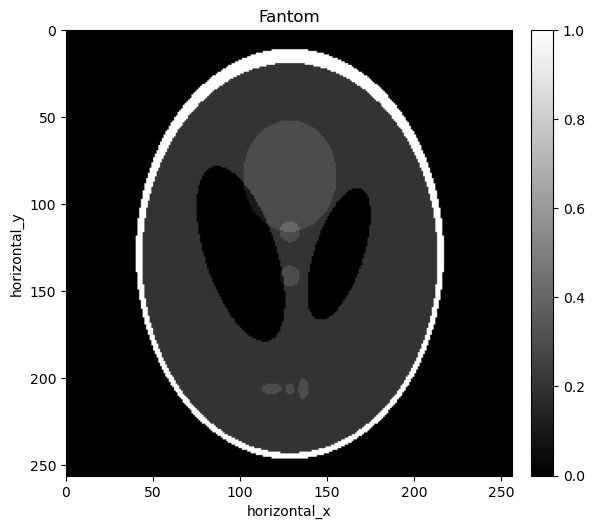

In [3]:
show2D(phantom, title='Fantom', cmap=cmap, size=(10,10), origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/fantom.png')

Vi kan simulere en CT scanning ved at lave projektioner gennem fantomet. Du kan ændre på antallet af projektioner selv. 

Først sætter vi scanningsgeometrien op og så generer vi projektioner.

In [4]:
# Parametre du kan skrue på
no_proj = 200

# Angles
angles = np.linspace(0, 180, no_proj, endpoint=False, dtype=np.float32)


# Definer scanningsgeometri
no_det = int(n_pixels*np.sqrt(2))
ag = AcquisitionGeometry.create_Parallel2D()\
                            .set_angles(angles)\
                            .set_panel(no_det, pixel_size=np.sqrt(2)/no_det)

# Definer projektions operator med Astra-Toolbox.
A = ProjectionOperator(ig, ag, device)

# Udfør projektioner og få et sinogram
sino_true = A.direct(phantom)    

Nu kigger vi på det genererede sinogram:

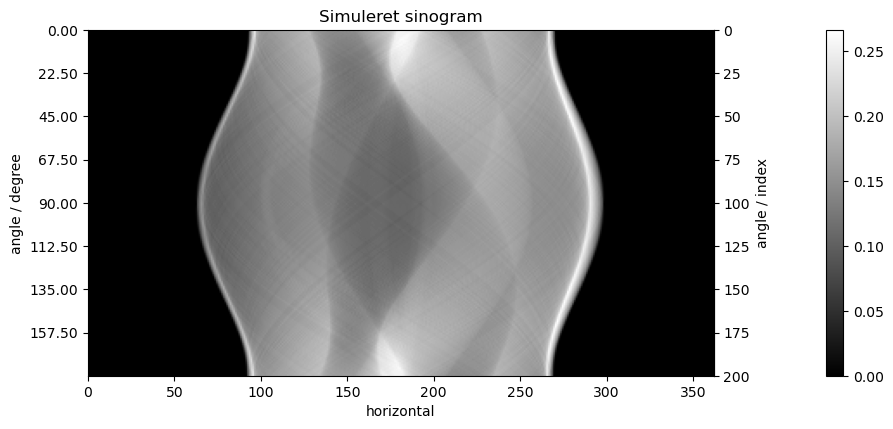

In [5]:
# Visualiser data
show2D(sino_true, title='Simuleret sinogram', cmap=cmap, size=(10,8), origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/sino.png')

For at det syntetiske eksperiment er endnu tættere på virkeligheden kan vi tilføje støj og plotte det støjfyldte sinogram. Du kan skrue på støjniveauet ved at ændre på parameteren "rnl" (random noise level). Den angiver støjniveauet i procent i forhold til det "rene" signal. 

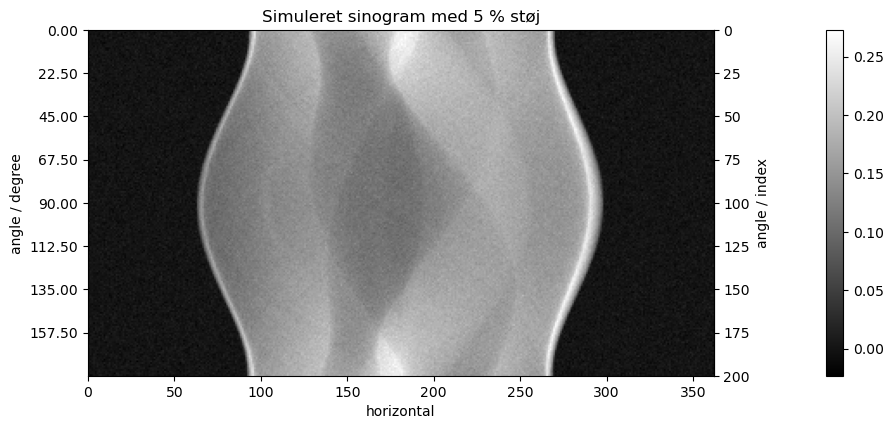

In [6]:
# Parametre du kan ændre på
rnl = 0.05   # Støjniveau i procent. Du kan også vælge 0, hvis du vil rekonstruere uden støj på sinogrammet. 

# Generer og tilføj støj til sinogram
sino_array = sino_true.as_array()
e0 = np.random.normal(0, 1, np.shape(sino_array))
noise_std = rnl*np.linalg.norm(sino_array)/np.linalg.norm(e0)
sino_noisy_array = sino_array + noise_std*e0

# Indsæt støjfyldt sinogram i CIL's datastruktur
sino_noisy = ag.allocate()
sino_noisy.fill(sino_noisy_array)

# Visualiser data
show2D(sino_noisy, title='Simuleret sinogram med {} % støj'.format(int(rnl*100)), cmap=cmap, size=(10,8), origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/sino_noisy.png')

Nu har vi genereret data vi kan rekonstruere.

## Tilbageprojektion

Vi starter med at se hvordan tilbageprojektionen af sinogrammet ser ud. Husk, dette er ikke den sande inverse, og vi forventer et slørret resultat.

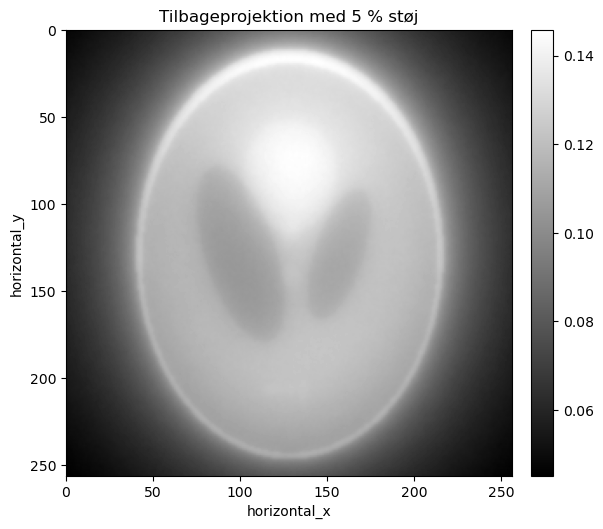

In [7]:
# Tilbageprojektion
recon_BP = A.adjoint(sino_noisy) 

# Visualiser data
show2D(recon_BP, title='Tilbageprojektion med {} % støj'.format(int(rnl*100)), cmap=cmap, size=(10,10), origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/BP.png')

## Filtered backprojektion

Nu rekonstruerer vi vha. Filtered Backprojection (FBP), som i grænsen med uendligt mange projektioner og ingen støj er den sande inverse. 

Prøv at reducer antallet af projektioner og/eller øg støjniveauet og se hvordan det påvirker rekonstruktionen. 

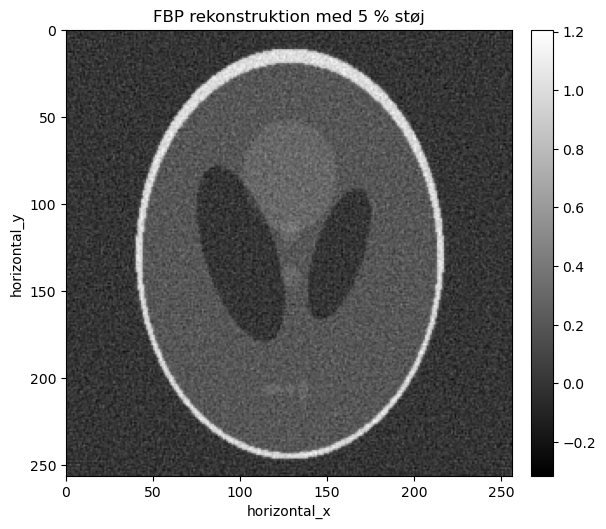

In [8]:
# Sæt FBP algoritmen op.
fbp = FBP(ig, ag, device)

# Kør rekonstruktion
recon_FBP = fbp(sino_noisy)

# Visualiser rekonstruktion
show2D(recon_FBP, title='FBP rekonstruktion med {} % støj'.format(int(rnl*100)), cmap=cmap, size=(10,10), origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/FBP.png')

## Algebraisk rekonstruktion

Til sidst går vi videre til algebraisk rekonstruktion, hvor vi rekonstruerer ved mindste kvadraters fit. Vi bruger en iterativ algoritme der hedder CGLS til at løse problemet. 

Prøv igen at reducere antallet af projektioner og/eller øg støjniveauet. Hvordan er rekonstruktionen i forhold til FBP. Hvor lang tid tager det at beregne?

Vi sætter CGLS algoritmen op:

In [9]:
# Startgæt
initial = ig.allocate(0)

# setup CGLS
cgls = CGLS(initial=initial, 
            operator=A, 
            data=sino_noisy,
            max_iteration = 200,
            update_objective_interval = 1)

Vi kører et antal iterationer af CGLS algoritmen her. 
Bemærk, hvis du kører denne celle to gange i træk husker algoritmen hvor langt den var kommet og fortsætter. Altså har du kørt 20 iterationer. For at starte forfra skal du køre cellen hvor algoritmen sættes op igen. 

In [10]:
# run N interations
cgls.run(30, verbose=True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        200         0.000          1.01663e+03
        1        200         0.009          1.02949e+02
        2        200         0.010          3.54831e+01
        3        200         0.009          2.06436e+01
        4        200         0.009          1.19789e+01
        5        200         0.009          6.98978e+00
        6        200         0.009          4.39270e+00
        7        200         0.009          4.06032e+00
        8        200         0.009          3.21661e+00
        9        200         0.009          2.61341e+00
       10        200         0.009          2.22865e+00
       11        200         0.009          2.04580e+00
       12        200         0.009          1.94137e+00
       13        200         0.009          1.81225e+00
       14        200         0.009          1.71316e+00
       15        200         0.009          1.58

Vi kan nu visualisere og gemme rekonstruktionen.

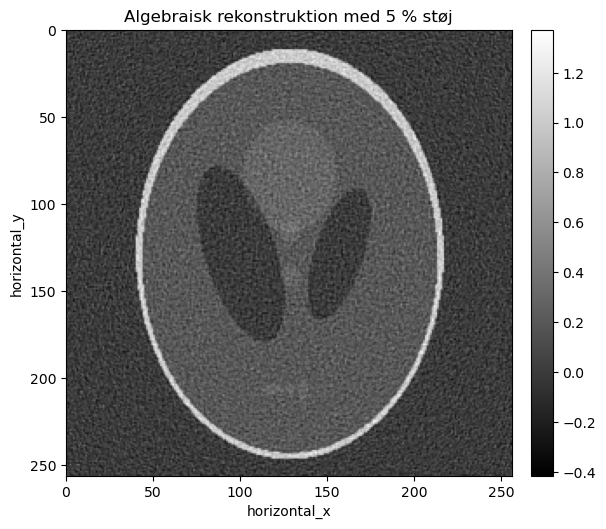

In [11]:
# Gem cgls resultat i variabel
recon_cgls = cgls.solution

# Visualiser rekonstruktion
show2D(recon_cgls, title='Algebraisk rekonstruktion med {} % støj'.format(int(rnl*100)), cmap=cmap, size=(10,10), origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/cgls.png')

## Bonus - Introducer begrænsninger i den algebraiske løsning

Ovenfor har du måske set at mindste kvadraters fit rekonstruktionen ikke er meget bedre end FBP. Men i tilfælde hvor vi har få projektioner eller meget støj kan det være nyttigt at introducere begrænsninger i løsningen. Det kan kun lade sig gøre med algebraiske metoder. 

Her kan du se resultatet af forskellige typer begrænsninger. Vi kommer ikke nærmere ind på hvordan begrænsningerne inkorporeres i matematikken, disse eksperimenter er blot en introduktion til de mange muligheder man har i tomografisk rekontruktion.

#### Positive absorptionskoefficienter

Ifølge fysikken er alle absorptionskoefficienter positive eller 0. Men det kender matematikken ikke til, det er vi nødt til at introducere som en begrænsning. Denne lille ændring kan give signifikant forbedring i rekonstruktionerne.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.01663e+03
       10        100         0.009          1.26007e+01
       20        100         0.009          3.83087e+00
       30        100         0.009          2.49026e+00
       40        100         0.009          2.14318e+00
       50        100         0.009          1.97962e+00
-------------------------------------------------------
       50        100         0.009          1.97962e+00
Stop criterion has been reached.



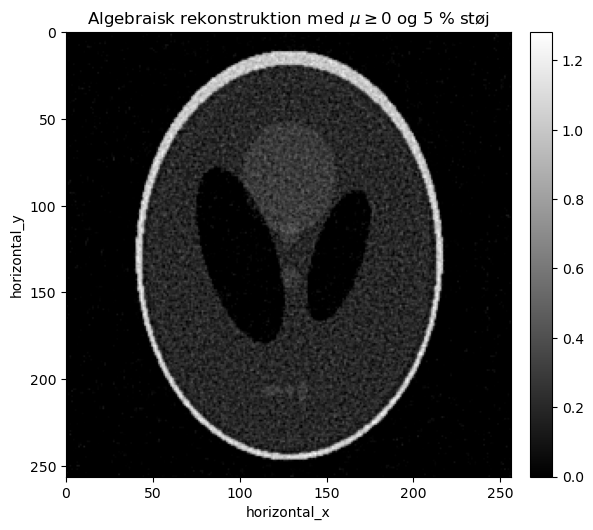

<Figure size 640x480 with 0 Axes>

In [12]:
# Sæt algoritme op og kør
F = LeastSquares(A, sino_noisy)
Gnonneg = IndicatorBox(lower=0.0)
myFISTA_nonneg = FISTA(f=F, 
                  g=Gnonneg, 
                  initial=initial, 
                  max_iteration=100, 
                  update_objective_interval=10)
myFISTA_nonneg.run(50, verbose=1)

# Gem rekonstruktion i variabel
recon_nonneg = myFISTA_nonneg.solution

# Visualiser rekonstruktion
show2D(recon_nonneg, 
       title='Algebraisk rekonstruktion med $\mu\geq 0$ og {} % støj'.format(int(rnl*100)), 
       cmap=cmap, 
       size=(10,10), 
       origin='upper-left')
plt.savefig('./SyntetiskeEksperimenterFigurer/recon_nonneg.png')

#### Dæmpe støj

Med denne begrænsning dæmper vi værdien af alle pixels. Det vil have størst effekt på store udsving og hjælper med at udglatte støj. MEN det udglatter også skarpe kanter i billedet. Du kan skrue på parameteren alpha for at glatte mere eller mindre. 

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.01663e+03
       10        100         0.009          2.79223e+01
       20        100         0.009          2.32695e+01
       30        100         0.009          2.30627e+01
       40        100         0.009          2.30101e+01
       50        100         0.009          2.29959e+01
-------------------------------------------------------
       50        100         0.009          2.29959e+01
Stop criterion has been reached.



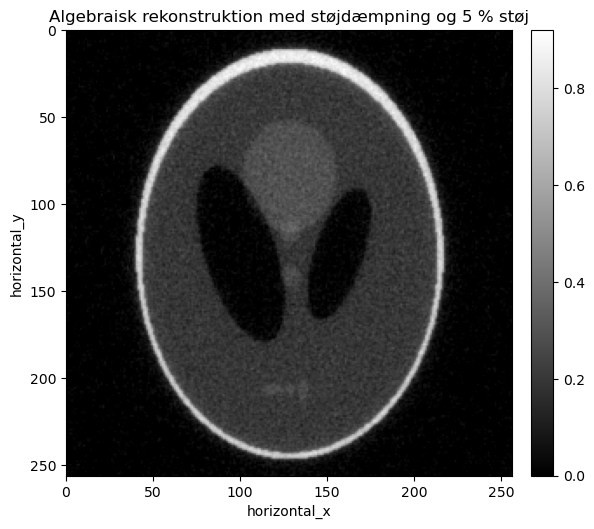

In [13]:
# Sæt algoritme op og kør
alpha = 0.08
D = IdentityOperator(ig)
Atilde = BlockOperator(A, alpha*D)
z = D.range.allocate(0.0)
btilde = BlockDataContainer(sino_noisy, z)
Ftilde = LeastSquares(Atilde, btilde)
myFISTA_Tikhonov = FISTA(f=Ftilde, 
                  g=Gnonneg,
                  initial=initial, 
                  max_iteration=100, 
                  update_objective_interval=10)
myFISTA_Tikhonov.run(50, verbose=1)

# Gem rekonstruktion i variabel
recon_smooth = myFISTA_Tikhonov.solution

# Visualiser rekonstruktion
show2D(recon_smooth, 
       title='Algebraisk rekonstruktion med støjdæmpning og {} % støj'.format(int(rnl*100)), 
       cmap=cmap, 
       size=(10,10), 
       origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/recon_smooth.png')

#### Promovere skarpe kanter

Med denne begrænsning sørger vi for at pixels der ligger tæt på hinanden oftest har samme værdi. Men vi tillader at der er store spring få steder, det åbner for muligheden for skarpe kanter. Denne metode er "state-of-the-art" i tomografisk rekonstruktion og kaldes "Total-Variation". Igen kan du skrue på parameteren alpha for at justere så du får den bedst mulige rekonstruktion.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.01663e+03
       10       1000         0.019          1.35194e+01
       20       1000         0.018          5.23674e+00
       30       1000         0.017          4.16437e+00
       40       1000         0.017          3.97560e+00
       50       1000         0.017          3.89878e+00
-------------------------------------------------------
       50       1000         0.017          3.89878e+00
Stop criterion has been reached.



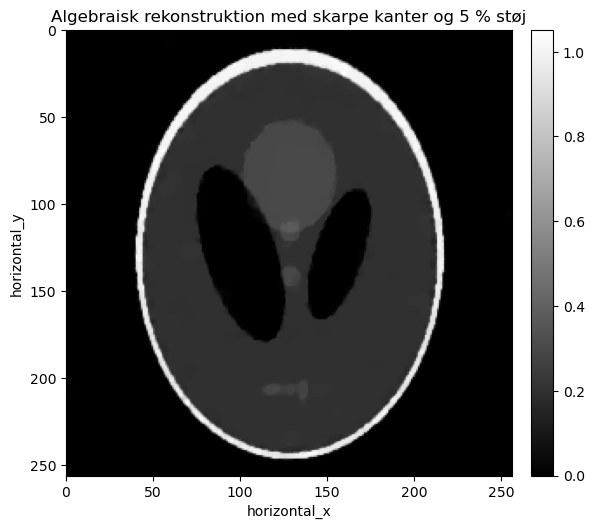

In [14]:
# Sæt algoritme op og kør
alpha = 0.001
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')
myFISTA_TV = FISTA(f=F, 
                  g=TV, 
                  initial=initial, 
                  max_iteration=1000, 
                  update_objective_interval=10)
myFISTA_TV.run(50, verbose=1)

# Gem rekonstruktion i variabel
recon_sharp = myFISTA_TV.solution

# Visualiser rekonstruktion
show2D(recon_sharp, 
       title='Algebraisk rekonstruktion med skarpe kanter og {} % støj'.format(int(rnl*100)), 
       cmap=cmap, 
       size=(10,10), 
       origin='upper-left')
#plt.savefig('./SyntetiskeEksperimenterFigurer/recon_sharp.png')

## Hurtig sammenligning

Hvis du ændrer på parametre og hurtigt vil sammenligne forskellige rekonstruktionsmetoder kan du køre hele Notebook'en og se her. Du kan også selv prøve at ændre på hvilke rekonstruktioner der vises. Det kan være nyttigt hvis du ønsker flere plots med samme colorbar. Kommentarerne i koden kan hjælpe. 

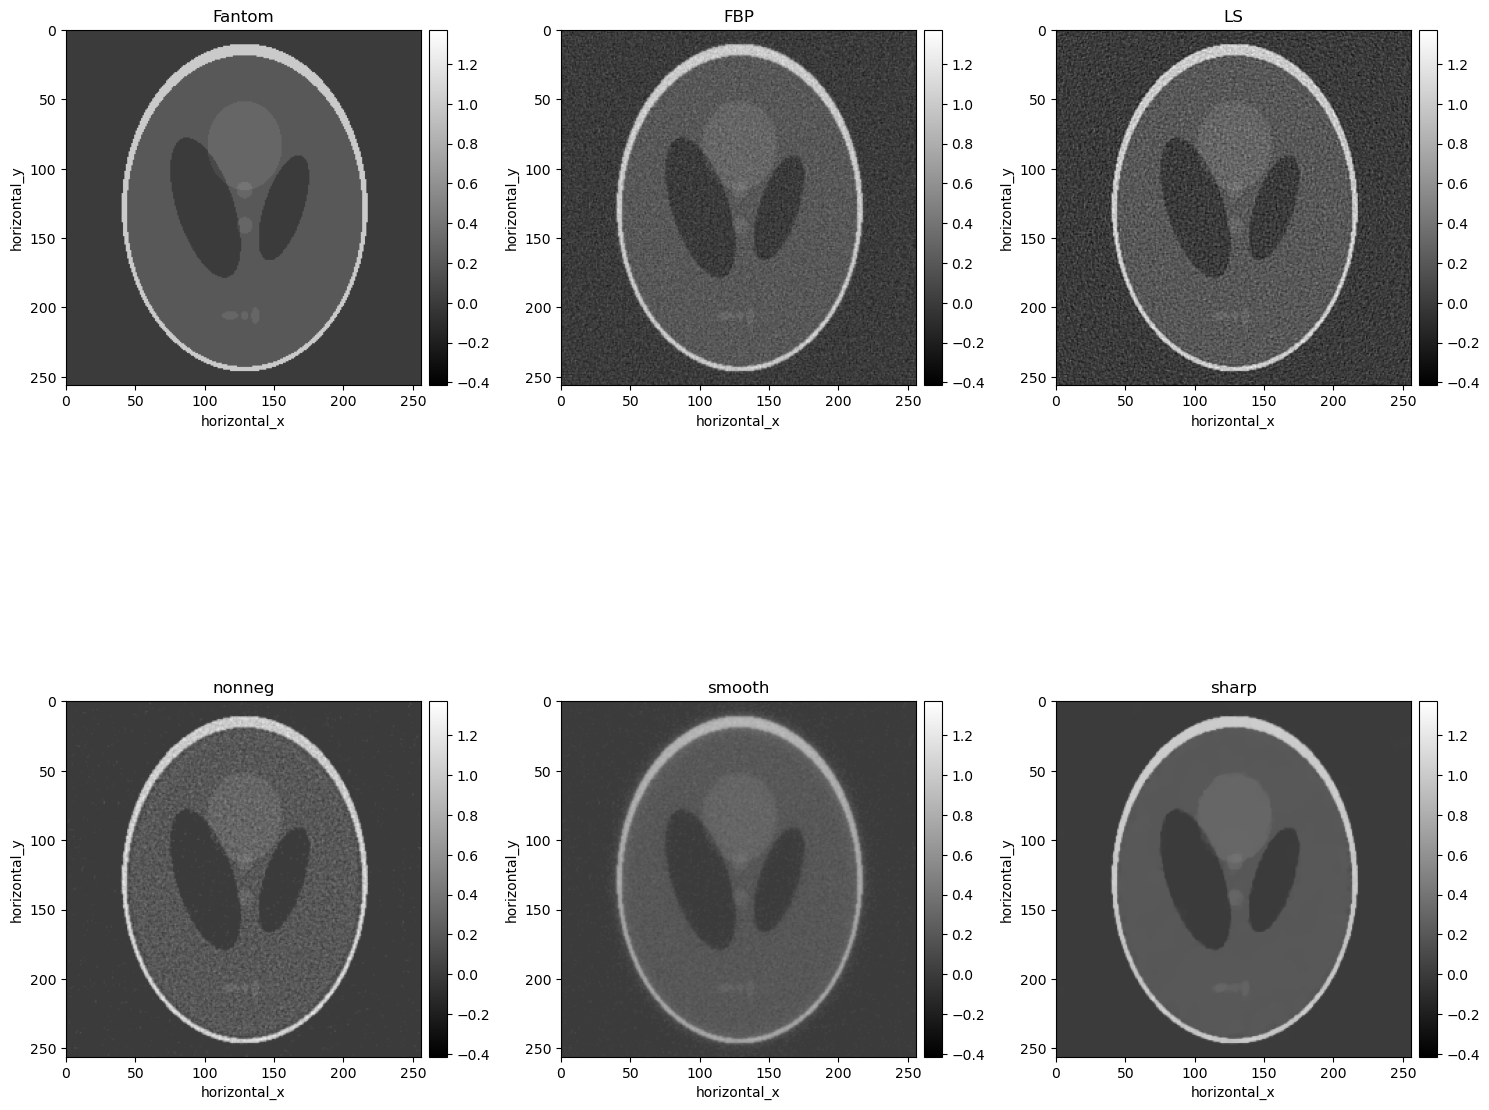

In [15]:
show2D([phantom, recon_FBP, recon_cgls, recon_nonneg, recon_smooth, recon_sharp], # variabel navne på rekonstruktioner
           ['Fantom', 'FBP', 'LS', 'nonneg', 'smooth', 'sharp'],          # Titel
           cmap=cmap, # farve på plot
           num_cols=3, # antal kolonner i figuren
           size=(15,15), # størrelse på figuren i inches
           origin='upper-left', # hvilket hjørne der er nulpunkt for plottet
           fix_range=True) # Sæt alle plots med samme colorbar. 
#plt.savefig('./SyntetiskeEksperimenterFigurer/recon_sammenlign.png')